In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filename in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname,filename)

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img,img_to_array,save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
dataset_path='D:\Bloodpred\dataset\dataset_blood_group'

In [4]:
BATCH_SIZE=32

In [5]:
# Step 1:::Load Dataset
dataset=image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64,64),  #resize image to standard size
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 6000 files belonging to 8 classes.


In [6]:
#Step 2:::Check Class Distribution
class_names=dataset.class_names
class_counts=Counter()
for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())]+=1

print("Class Distribution:")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")

Class Distribution:
B+: 652
O+: 852
A+: 565
A-: 1009
B-: 741
O-: 712
AB-: 761
AB+: 708


In [8]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_names,class_counts):

     
    classes=[class_names[i] for i in class_counts.keys()]
    counts=[class_counts[i] for i in class_counts.keys()]

    plt.figure(figsize=(10,6))
    plt.bar(classes, counts, color='skyblue', edgecolor='black')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


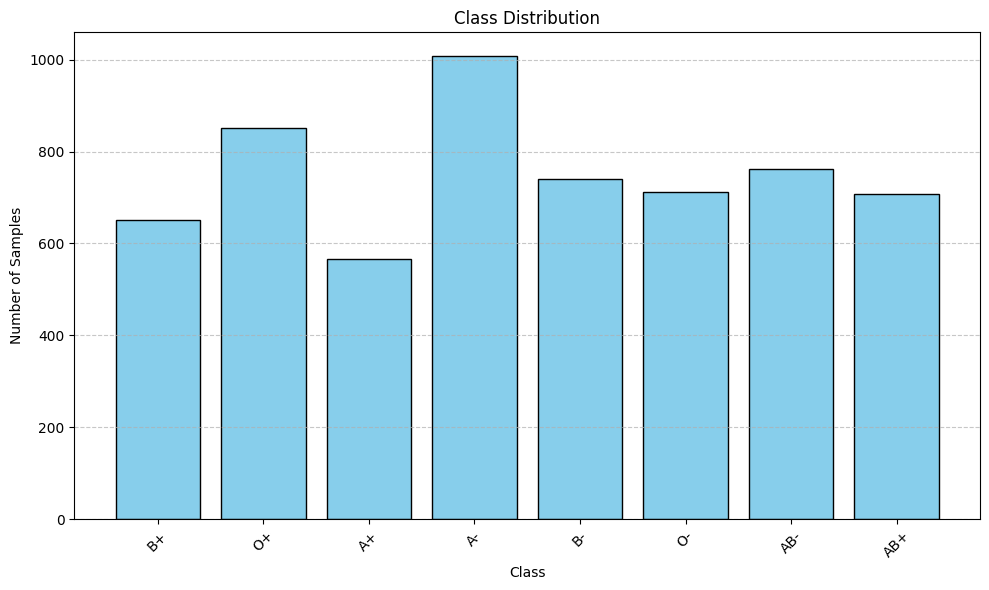

In [9]:
plot_class_distribution(class_names,class_counts)

In [10]:
max_count=max(class_counts.values())

In [11]:
def oversample_class(class_id,count,max_count):
    unbatched_dataset=dataset.unbatch()
    class_dataset =unbatched_dataset.filter(lambda img,lbl: tf.equal(lbl, class_id))
    repeat_factor =max_count//count+(max_count%count>0)
    return class_dataset.repeat(repeat_factor).take(max_count)

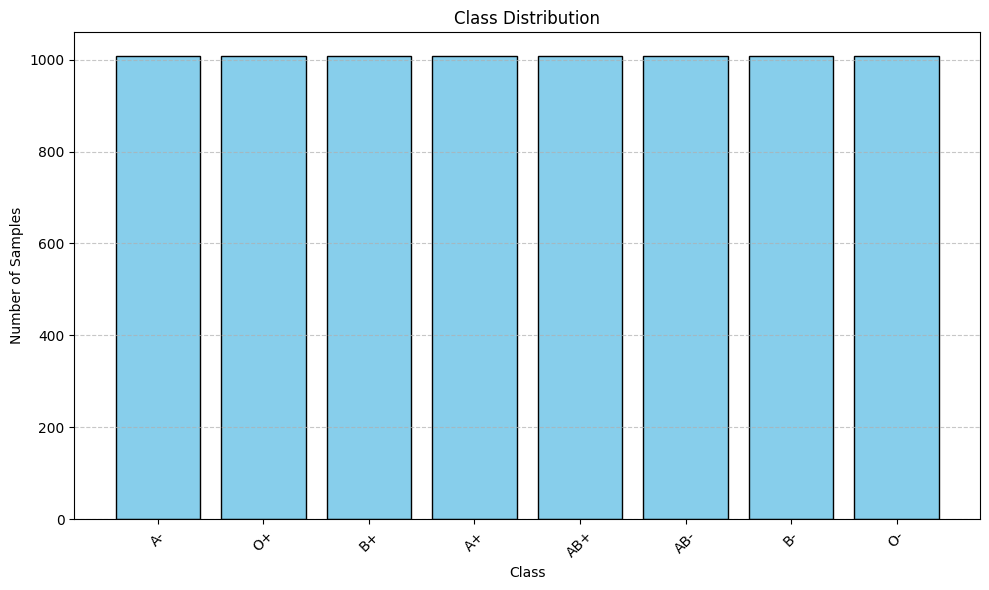

In [12]:
balanced_datasets=[]
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_count))

balanced_dataset=tf.data.Dataset.sample_from_datasets(balanced_datasets)
balanced_class_counts= Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names, balanced_class_counts)
balanced_dataset=balanced_dataset.batch(BATCH_SIZE,drop_remainder=True)

In [13]:
for sample in balanced_dataset.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [14]:
balanced_dataset_unbatched=balanced_dataset.unbatch()
dataset_size=sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")

Total dataset size: 8064


In [15]:
train_ratio=0.7
val_ratio=0.2
balanced_dataset_unbatched=balanced_dataset.unbatch()
train_size=int(train_ratio * dataset_size)
val_size=int(val_ratio * dataset_size)

train_dataset=balanced_dataset_unbatched.take(train_size)
val_test_dataset=balanced_dataset_unbatched.skip(train_size)
val_dataset=val_test_dataset.take(val_size)
test_dataset=val_test_dataset.skip(val_size)

train_dataset=train_dataset.batch(BATCH_SIZE,drop_remainder=True)
val_dataset=val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset=test_dataset.batch(BATCH_SIZE,drop_remainder=True)

train_batch_count=sum(1 for _ in train_dataset)
val_batch_count=sum(1 for _ in val_dataset)
test_batch_count=sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")

Training dataset size: 5632
Validation dataset size: 1600
Testing dataset size: 800


In [16]:
def create_high_accuracy_model():
    model=tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3),activation='relu', padding='same',input_shape=(None, None, 3)),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3,3),activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3,3),activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3,3),activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3,3),activation='relu', padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(len(class_names),activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


high_acc_model=create_high_accuracy_model()

c:\Users\gurup\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)
early_stop=EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

In [18]:
history_high_acc=high_acc_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[reduce_lr,early_stop]
)

Epoch 1/50
    176/Unknown 45s 237ms/step - accuracy: 0.1287 - loss: 9.1698

c:\Users\gurup\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 65s 351ms/step - accuracy: 0.1287 - loss: 9.1382 - val_accuracy: 0.1299 - val_loss: 2.0387 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 61s 344ms/step - accuracy: 0.1265 - loss: 2.0802 - val_accuracy: 0.1299 - val_loss: 2.0390 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 65s 366ms/step - accuracy: 0.1596 - loss: 2.0600 - val_accuracy: 0.2347 - val_loss: 1.8943 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 66s 372ms/step - accuracy: 0.2351 - loss: 1.9063 - val_accuracy: 0.3297 - val_loss: 1.7574 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 61s 346ms/step - accuracy: 0.3395 - loss: 1.7066 - val_accuracy: 0.4528 - val_loss: 1.4333 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 63s 355ms/step - accuracy: 0.4331 - loss: 1.4778 - val_accuracy: 0.4203 - val_loss: 1.3963 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 67s 375ms/step - accuracy: 0.5271 - loss:

In [ ]:
high_acc_eval=high_acc_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy:{high_acc_eval[1]}") 

50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.8942 - loss: 0.3540
High Accuracy Model - Loss: 0.34910041093826294, Accuracy:0.8792892098426819


In [ ]:
import matplotlib.pyplot as plt 
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

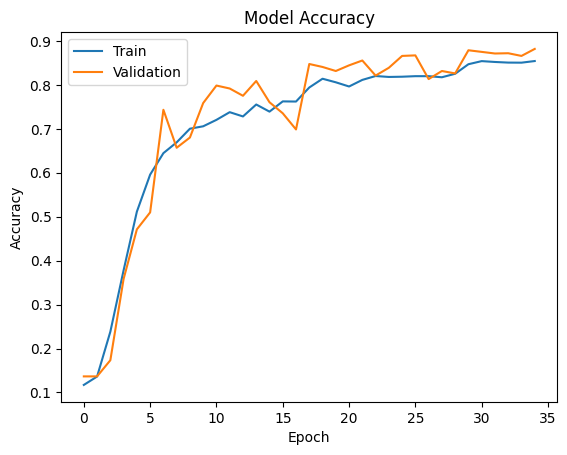

In [ ]:
plot_accuracy(history_high_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Claassification Report
              precision  

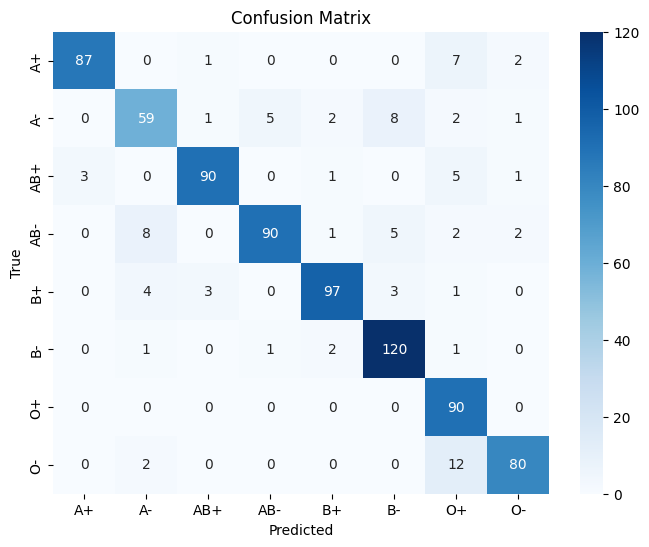

In [ ]:
y_true=[]
y_pred=[]
for images, labels in test_dataset:
    predictions=high_acc_model.predict(images)
    predicted_labels=np.argmax(predictions,axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

y_true=np.array(y_true)
y_pred= np.array(y_pred)

report=classification_report(y_true, y_pred, target_names=class_names)
print("Claassification Report")
print(report)

conf_matrix=confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
high_acc_model.save('D:/Bloodpred/model/model.h5')
print("Model saved as HDF5 format.")

Model saved as HDF5 format.
